In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Selection of version of tensorflow in colab
%tensorflow_version 2.x

# library import
import keras
import tensorflow as tf
from tensorflow.compat.v1  import  roll
import numpy as np
import cv2
from keras import optimizers
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Add, Lambda, Subtract,Layer,Cropping2D,Reshape
from keras.optimizers import *
from math import pi as pi
from scipy import signal
from keras import backend as K
from math import pi as pi
import matplotlib.pyplot as plt
import math
import os

from scipy.io import loadmat

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

!pip install LightPipes


print(tf.__version__)
print(keras.__version__)

from keras.constraints import Constraint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import misc
import glob
import imageio
from natsort import natsorted

     |████████████████████████████████| 51kB 3.1MB/s 
2.4.1
2.4.3


In [ ]:
# Functions

def spiral_kxky(filename, ledNum):
    kxky = [[], []]
    with open(filename, 'r') as file:
        for line in file:
            for j, value in enumerate(line.split(",")):
                kxky[j].append(np.float(value))
    kxky = np.asarray(kxky)
    kxky = kxky.T
    return kxky[:ledNum, :]


def show_result(model, show=0, noShow=10,size=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))
    
    c_complex = c_real + 1j * c_imag
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    
    if show:
        plt.figure(figsize=(size,size))
        plt.subplot(233),plt.imshow(np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1), cmap='gray'),plt.title('recover (abs)')
        ax = plt.subplot(232)
        plot = plt.imshow(im_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray')
        divider = make_axes_locatable(ax)
        plt.title('recover (phase)')
        cax = divider.append_axes("right", size="5%", pad=0.02)
        plt.colorbar(plot,cax=cax)
        plt.subplot(231),plt.imshow(im_spatial[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover FT')
        plt.show()
        plt.show()
        
    return c_complex


class MyLayer( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=True)

        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        a = tf.keras.backend.reshape(x, shape=(-1,imSize,imSize,1))
        return tf.multiply(a,self.kernel)

    def compute_output_shape(self, input_shape):
        return (self.output_dims)


class take_one( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(take_one, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=False)

        super(take_one, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        b = tf.keras.backend.reshape(x, shape=(1,1))
        a = tf.keras.backend.cast(b, dtype='int32')
        return a[:,0]*1

    def compute_output_shape(self, input_shape):
        return (self.output_dims)


class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value =  min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(10,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        h1,h2,h3,h4,h5,h6,h7,h8,h9,h10 = x
        a= self.lambd2[0,0]
        b= self.lambd2[1,0]
        c= self.lambd2[2,0]
        d= self.lambd2[3,0]
        e= self.lambd2[4,0]
        f= self.lambd2[5,0]
        g= self.lambd2[6,0]
        h= self.lambd2[7,0]
        i= self.lambd2[8,0]
        j= self.lambd2[9,0]
        # k= self.lambd2[10,0]
        # l= self.lambd2[11,0]

        new_ctf = a*h1 + b*h2 +  c*h3 + d*h4 + e*h5 + f*h6 + g*h7 + h*h8+i*h9 +j*h10#+ k*h11 +l*h12
        return new_ctf

    def compute_output_shape(self, input_shape):
        return input_shape[0]

class pos_cal(Layer):
    def __init__(self, **kwargs):
        super(pos_cal, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(1,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(pos_cal, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        a= self.lambd2[0,0]
        new_pos = x+a
        return new_pos

    def compute_output_shape(self, input_shape):
        return input_shape

        
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [ ]:
from PIL import Image
import numpy as np
import scipy.io

def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((k, j))

            images.append(slice_)

            print(i)
        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

In [ ]:
#input_img = 'app' # 0
input_img = 'cell' # 0
#input_img = 'cell_u' # 0
crop = 168 
name_total = "9994A323901"
if(input_img =='cell'):
  #cell = read_tiff('/content/drive/My Drive/Stage/RAW/9994A323901/infected_1356.tif',35)
  original = read_tiff('/content/drive/My Drive/Stage/9994A323910.tif',35)
  #cell = read_tiff('/content/drive/My Drive/Stage/RAW/9994A323901/healthy_1203.tif',35)
  
  ImgSizeBef = [2054,2456] 
  newsize =  np.array(ImgSizeBef)/2

  print((newsize[0]-crop/2),(newsize[0]+crop/2))
  divs = original[:,int(newsize[0]-crop/2):int(newsize[0]+crop/2),int(newsize[1]-crop/2):int(newsize[1]+crop/2)]
  for i in range(0,35):
  # Show CTF
    plt.figure(figsize=(15,15))
    plt.xticks(np.arange(0,crop,20))
    plt.subplot(1, 3, 3),plt.imshow(divs[i,:,:], cmap='gray'),plt.title(i)
    plt.show()

elif(input_img =='app'):
  cell =np.ndarray((25, crop, crop))

  ImgSizeBef = [2456+100,2054+100] 
  newsize =  np.array(ImgSizeBef)/2

  for i in range(1,26):
    img = Image.open('/content/drive/My Drive/Stage/apprentissage/raw_page_'+str(i).zfill(4)+'.tif')
    cell[i-1] = img.crop((newsize[0]-crop/2,newsize[1]-crop/2,newsize[0]+crop/2,newsize[1]+crop/2))


elif(input_img =='cell_u'):
  original =np.ndarray((35, crop, crop))
  travel = "/content/drive/My Drive/Stage/code_test_nicolas/data/save_cell/out/" + name_total +"/"
  file=os.listdir(travel)
  infected = []
  healthy =[]

  for arch in file:
    if 'infected' in arch:
      infected.append(arch)
    if 'healthy' in arch:
      healthy.append(arch)
  print(infected)
  i = 0
  celule = travel + infected[0] +'/'
  for image_path in natsorted(glob.glob(celule+'*.png')):
    image = imageio.imread(image_path)
    if 'mask' not in image_path:
      original[i] = image 
      i = i+1
  divs = original.copy()
  for i in range(0,35):
  # Show CTF
    plt.figure(figsize=(15,15))
    plt.xticks(np.arange(0,crop,20))
    plt.subplot(1, 3, 3),plt.imshow(divs[i,:,:], cmap='gray'),plt.title(i)
    plt.show()



In [ ]:
#cell = np.square(cell)
print(np.amin(divs))
print(np.amax(divs))

mi = np.amin(divs)
ma = np.amax(divs)

divs = np.square((255/ma)*divs)

print(np.amin(divs))
print(np.amax(divs))


543.0
3595.0
1483.481827449266
65025.0


In [ ]:
# Set parameters
index_downSample = 2 # downsample: index_downSample=4
wlength = 0.620*1e-6
NA = 0.75
k0 = 2 * pi / wlength
magnif = 20
spsize = (3.45*1e-6)/magnif
psize = spsize/index_downSample
print(wlength/(2*NA))
print(spsize)
crop = 168
imSize = int(crop*index_downSample)
imCenter = int(imSize / 2)
arraysize = 5.97
NAstep = 0.05
dz = 21


4.1333333333333333e-07
1.725e-07


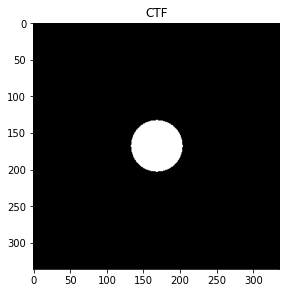

35.056451612903224


In [ ]:
# Generate CTF
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = (NA * k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= cutoffFrequency
CTF = CTF.astype(float)

# Show CTF
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0,crop,20))
plt.subplot(1, 3, 3),plt.imshow(CTF[:,:], cmap='gray'),plt.title('CTF')
plt.show()

print(cutoffFrequency)

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


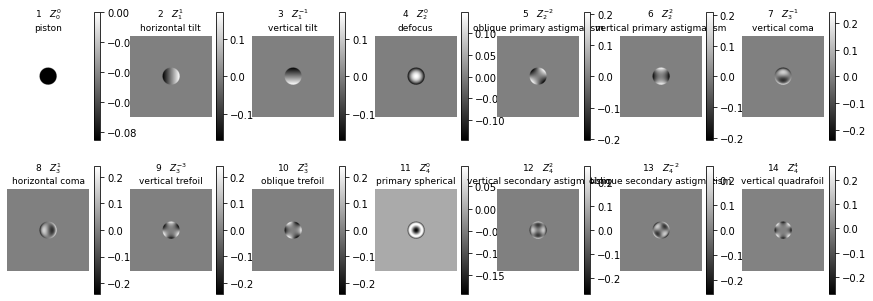

In [ ]:
from LightPipes import *
import matplotlib.pyplot as plt
import math

wavelength=wlength
cutoffFrequency = (NA * k0 / dkxy)

size=cutoffFrequency
N=imSize
A=wavelength/(N/2*math.pi)

poly = np.ndarray([21,imSize,imSize],dtype=np.float128)

plt.figure(figsize=(15,8)) 
for Noll in range (1,15):
    (nz,mz)=noll_to_zern(Noll)
    S=ZernikeName(Noll)
    F=Begin(N,psize,N)
    F=Zernike(nz,mz,size,A,F)
    F=CircAperture(size,0,0,F)
    Phi=Phase(F)
    Z = Phi
    poly[Noll-1] = Z
    
    # ax1 = plt.subplot(3,7,Noll)
    # plot = plt.imshow(np.real(Z), cmap='gray')
    # plt.colorbar(plot,ax=ax1)
    # s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    # plt.title(s, fontsize=9);plt.axis('off')

    ax1 = plt.subplot(3,7,Noll)
    plot = plt.imshow(poly[Noll-1], cmap='gray')
    plt.colorbar(plot,ax=ax1)
    s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    plt.title(s, fontsize=9);plt.axis('off')
plt.show()


In [ ]:
del Z,Phi,S,F

z1_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z2_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z3_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z4_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z5_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z6_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z7_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z8_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z9_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z10_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    z1_input[i, :, 0]  = np.reshape(poly[0],(imSize*imSize))
    z2_input[i, :, 0]  = np.reshape(poly[1],(imSize*imSize))
    z3_input[i, :, 0]  = np.reshape(poly[2],(imSize*imSize))
    z4_input[i, :, 0]  = np.reshape(poly[3],(imSize*imSize))
    z5_input[i, :, 0]  = np.reshape(poly[4],(imSize*imSize))
    z6_input[i, :, 0]  = np.reshape(poly[5],(imSize*imSize)) 
    z7_input[i, :, 0]  = np.reshape(poly[6],(imSize*imSize)) 
    z8_input[i, :, 0]  = np.reshape(poly[7],(imSize*imSize)) 
    z9_input[i, :, 0]  = np.reshape(poly[8],(imSize*imSize)) 
    z10_input[i, :, 0]  = np.reshape(poly[9],(imSize*imSize))
del poly

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z1 (InputLayer)                 [(None, 112896, 1)]  0                                            
__________________________________________________________________________________________________
z2 (InputLayer)                 [(None, 112896, 1)]  0                                            
__________________________________________________________________________________________________
z3 (InputLayer)                 [(None, 112896, 1)]  0                                            
__________________________________________________________________________________________________
z4 (InputLayer)                 [(None, 112896, 1)]  0                                            
_______________________________________________________________________________________

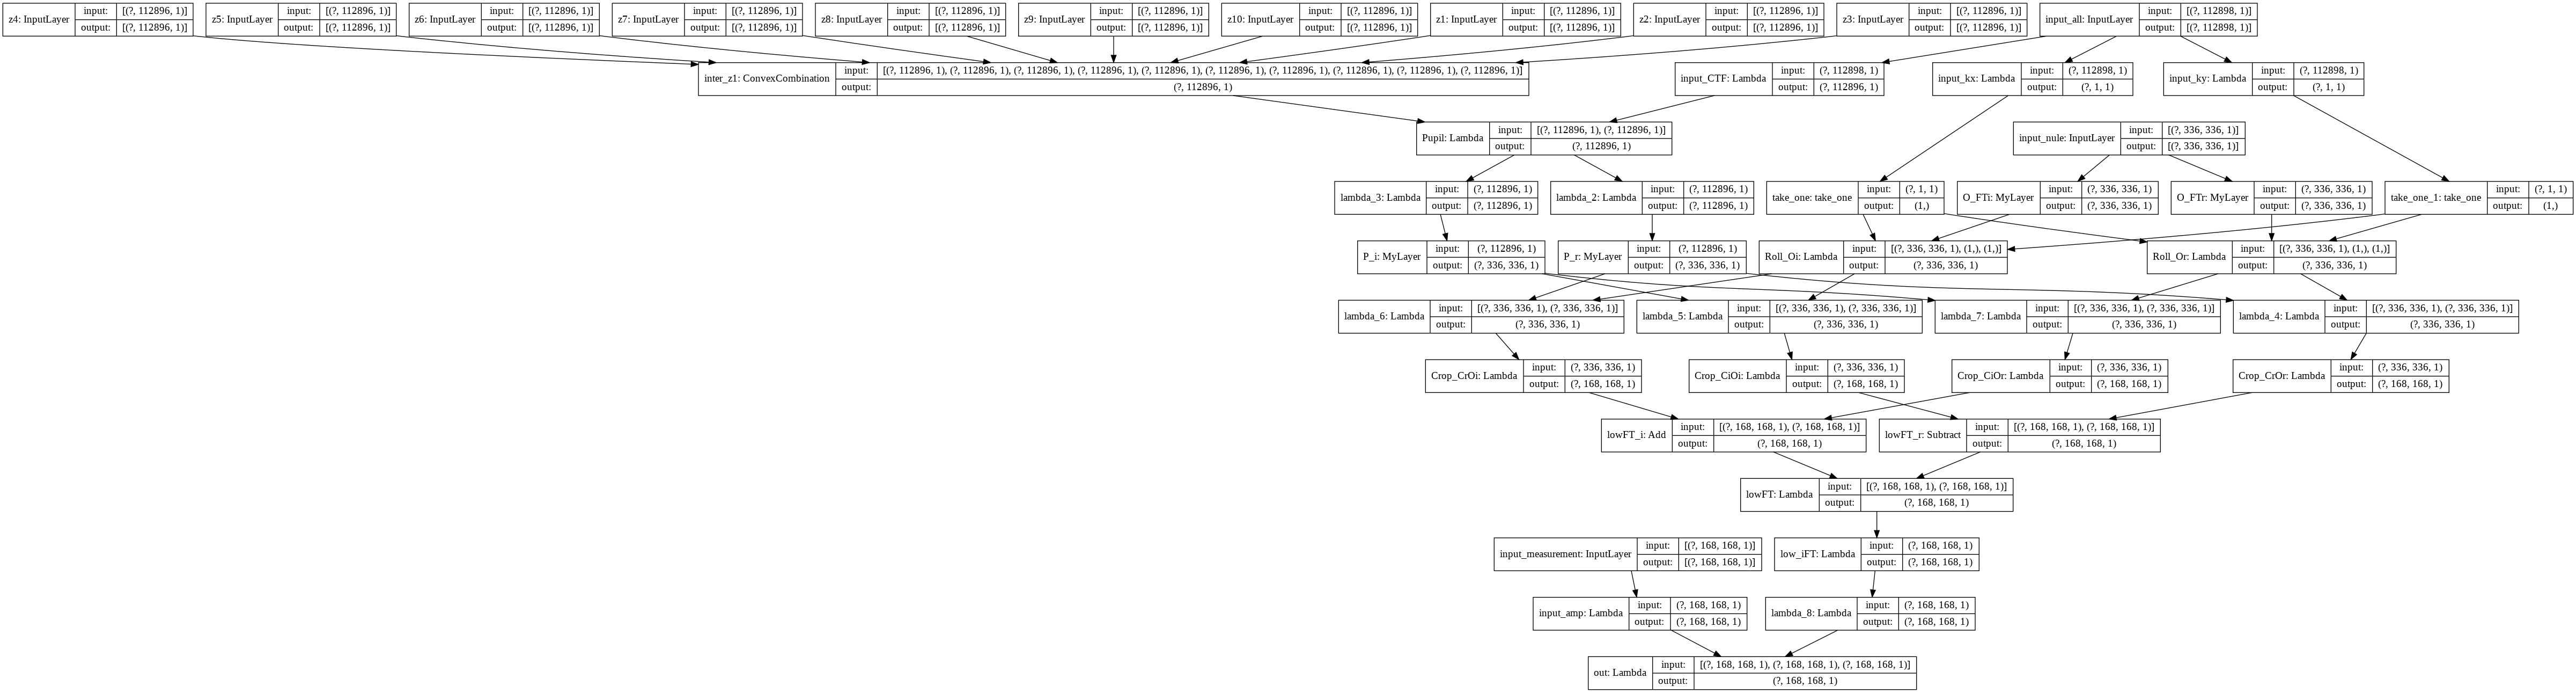

In [ ]:
center = imSize/2

input_all = Input((imSize*imSize+2, 1),dtype='complex64', name='input_all')  # CTF
input_measurement = Input((crop, crop, 1), name='input_measurement')  # measurement
nule = Input((imSize,imSize, 1),dtype='float32', name='input_nule')  # CTF tf.ones(tf.shape(input_CTF), tf.float32)

hx = int(center-crop/2)
hy = int(center +crop/2)

input_CTF = Lambda(lambda x: x[:,:imSize*imSize,:],name='input_CTF')(input_all)
input_kx = Lambda(lambda x:  tf.math.real(x[:,imSize*imSize:imSize*imSize+1,:]),name='input_kx')(input_all)
input_ky = Lambda(lambda x: tf.math.real(x[:,imSize*imSize+1:imSize*imSize+2,:]),name='input_ky')(input_all)

z1 = Input((imSize*imSize, 1),dtype='float', name='z1')  # CTF
z2 = Input((imSize*imSize, 1),dtype='float', name='z2')  # CTF
z3 = Input((imSize*imSize, 1),dtype='float', name='z3')  # CTF
z4 = Input((imSize*imSize, 1),dtype='float', name='z4')  # CTF
z5 = Input((imSize*imSize, 1),dtype='float', name='z5')  # CTF
z6 = Input((imSize*imSize, 1),dtype='float', name='z6')  # CTF
z7 = Input((imSize*imSize, 1),dtype='float', name='z7')  # CTF
z8 = Input((imSize*imSize, 1),dtype='float', name='z8')  # CTF
z9 = Input((imSize*imSize, 1),dtype='float', name='z9')  # CTF
z10 = Input((imSize*imSize, 1),dtype='float', name='z10')  # CTF
z11 = Input((imSize*imSize, 1),dtype='float', name='z11')  # CTF
z12 = Input((imSize*imSize, 1),dtype='float', name='z12')  # CTF


kx_i = take_one((1,),input_shape = (1,1))(input_kx)
ky_i = take_one((1,),input_shape = (1,1))(input_ky)

# define O (FT)
O_FTr = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTr')
O_FTi = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTi')

# define P
P_r = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_r')
P_i = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_i')

# CTF * O (FT)
CTFr = Lambda(lambda x: tf.math.real(x))(input_CTF)
CTFi = Lambda(lambda x: tf.math.imag(x))(input_CTF)


Comb = ConvexCombination(name='inter_z1')([z1,z2,z3,z4,z5,z6,z7,z8,z9,z10])

Pupil = Lambda(lambda x: tf.exp(1j*tf.cast(x[0],tf.complex64))*x[1],name='Pupil')([Comb,input_CTF])


Pupil_r = Lambda(lambda x: tf.math.real(x))(Pupil)
Pupil_i = Lambda(lambda x: tf.math.imag(x))(Pupil)


P_cr = P_r(Pupil_r)
P_ci = P_i(Pupil_i)

Or = O_FTr(nule)
Oi = O_FTi(nule)

#tfa.image.translate(x[0],translations=[x[1][0],x[2][0]] ,interpolation='BILINEAR',name='Roll_Or') 

Or_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Or')([Or,kx_i,ky_i])  
Oi_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Oi')([Oi,kx_i,ky_i])


CrOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Or_d])
CiOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Oi_d])
CrOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Oi_d])
CiOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Or_d])

CrOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOr')(CrOr_c)
CiOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOi')(CiOi_c)
CrOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOi')(CrOi_c)
CiOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOr')(CiOr_c)

# generate low resolution image (FT)
lowFT_r = Subtract(name='lowFT_r')([CrOr, CiOi])
lowFT_i = Add(name='lowFT_i')([CrOi, CiOr])

lowFT = Lambda(lambda x: tf.cast(x[0], tf.complex64) + 1j * tf.cast(x[1], tf.complex64),name='lowFT')([lowFT_r, lowFT_i])
# do ifft
im_iFT = Lambda(lambda x: tf.signal.ifft3d(tf.signal.ifftshift(tf.cast(x, tf.complex64))),name='low_iFT')(lowFT)

image = Lambda(lambda x: tf.abs(x))(im_iFT)
# keep angle, and use sqrt(I) to change the anplitude
iFT_angle = Lambda(lambda x: tf.math.angle(tf.cast(x, tf.complex64)),name='low_iFT_angle')(im_iFT)

sqrtI = Lambda(lambda x: tf.sqrt(x),name='input_amp')(input_measurement)

output = Lambda(lambda x: tf.multiply(tf.cast(tf.divide(tf.reduce_sum(x[0]),tf.reduce_sum(x[1])), tf.float32),x[2]),output_shape=(crop,crop,1),name='out')([sqrtI, image,image])

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
model.summary()


keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)



In [ ]:
!pip install geneticalgorithm

     |████████████████████████████████| 51kB 4.9MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp36-none-any.whl size=15078 sha256=e8243408358bf75c6a1d79dc5818982c0cea49c20e2eb35556625bff14d2dd07
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/My Drive/Stage/Code/FPM_Simulation_exitWaveNet/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

In [ ]:
print(kakr[1:2,0])

[49.49806213]


In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 1

def f(X):
  kx_i[led,0,0] = kx_i[led,0,0] + X[0] 
  ky_i[led,0,0] = ky_i[led,0,0] + X[1]

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_squared_error", optimizer=adam)
  history = model.fit([imgs_train_input3[1:2], imgs_train_input2[1:2],imgs_train_input4[1:2],z1_input[1:2],z2_input[1:2],z3_input[1:2],z4_input[1:2],z5_input[1:2],z6_input[1:2],z7_input[1:2],z8_input[1:2],z9_input[1:2],z10_input[1:2]],imgs_test_predict[1:2], batch_size=1, epochs=2, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-10,10],[-10,10]])
vartype=np.array([['int'],['int']])

algorithm_param = {'max_num_iteration': 50,\
                   'population_size':200,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

|_________________________________________________ 2.0% GA is running...WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_train_function.<locals>.train_function at 0x7fd5c95f6950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
||________________________________________________ 4.0% GA is running...WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_train_function.<locals>.train_fu

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])

12.577638626098633


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/My Drive/Stage/Code/FPM_Simulation_exitWaveNet/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

 The best solution found:
 [ 2.23270515 -0.7429608 ]

 Objective function:
 12.558894157409668


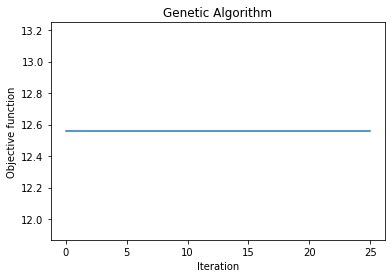

7799.809499979019


In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 8
def f(X):
  kakr_n[led,0] = kakr[led,0] + X[0] 
  kakr_n[led,1] = kakr[led,0] + X[1]

  kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
  ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_absolute_error", optimizer=adam)
  history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-15.0,15.0],[-1.0,1.0]])
vartype=np.array([['real'],['real']])

algorithm_param = {'max_num_iteration': 25,\
                   'population_size':400,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])

12.595626831054688


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/MyDrive/Stage_colab_shared/data/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

 The best solution found:
 [ 2.59840974 -0.71413689]

 Objective function:
 12.528377532958984


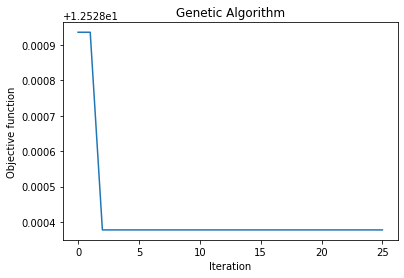

7911.852942466736


In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 9
def f(X):
  kakr_n[led,0] = kakr[led,0] + X[0] 
  kakr_n[led,1] = kakr[led,0] + X[1]

  kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
  ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_absolute_error", optimizer=adam)
  history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-15.0,15.0],[-1.0,1.0]])
vartype=np.array([['real'],['real']])

algorithm_param = {'max_num_iteration': 25,\
                   'population_size':400,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])

12.579858779907227


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/My Drive/Stage/Code/FPM_Simulation_exitWaveNet/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

 The best solution found:
 [-11.42995296   0.16722804]

 Objective function:
 12.547320365905762


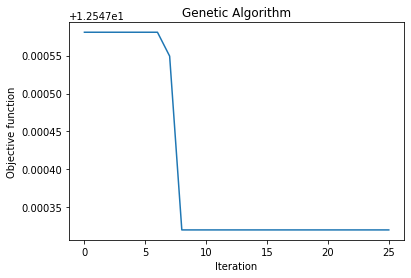

7905.705082416534


In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 17
def f(X):
  kakr_n[led,0] = kakr[led,0] + X[0] 
  kakr_n[led,1] = kakr[led,0] + X[1]

  kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
  ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_absolute_error", optimizer=adam)
  history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-20.0,20.0],[-1.0,1.0]])
vartype=np.array([['real'],['real']])

algorithm_param = {'max_num_iteration': 25,\
                   'population_size':400,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])

12.578556060791016


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/My Drive/Stage/Code/FPM_Simulation_exitWaveNet/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

 The best solution found:
 [11.21749978  0.98731911]

 Objective function:
 12.51730728149414


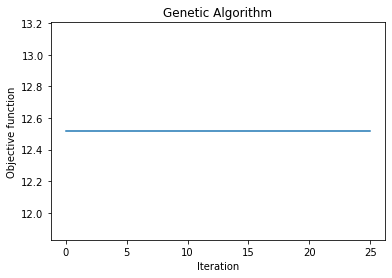

7960.805675506592


In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 19
def f(X):
  kakr_n[led,0] = kakr[led,0] + X[0] 
  kakr_n[led,1] = kakr[led,0] + X[1]

  kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
  ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_absolute_error", optimizer=adam)
  history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-20.0,20.0],[-1.0,1.0]])
vartype=np.array([['real'],['real']])

algorithm_param = {'max_num_iteration': 25,\
                   'population_size':400,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])

12.587422370910645


In [ ]:
cell = divs

# Generate CTFs
imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    imgs_train_input2[i, :, :, 0] = cell[i]
    imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)
weight_or = np.ndarray((1, imSize, imSize, 1))
weight_oi = np.ndarray((1, imSize, imSize, 1))

weight_pr = np.ndarray((1, imSize, imSize, 1))
weight_pi = np.ndarray((1, imSize, imSize, 1))

weight_z1 = np.zeros((10, 1))

CTF_r = np.ndarray((1, imSize, imSize, 1))
CTF_i = np.ndarray((1, imSize, imSize, 1))

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

kakr_n = np.ndarray((int(arraysize ** 2),2),dtype=np.float32) # input measurement

kakr = spiral_kxky('/content/drive/My Drive/Stage/Code/FPM_Simulation_exitWaveNet/pos_all_2.txt',int( arraysize ** 2)) # load kx, ky here

for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])

import time

In [ ]:
import numpy as np
import math
from geneticalgorithm import geneticalgorithm as ga
model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
start = time.time()
led = 20
def f(X):
  kakr_n[led,0] = kakr[led,0] + X[0] 
  kakr_n[led,1] = kakr[led,0] + X[1]

  kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
  ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

  imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

  imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

  imgs_test_predict = np.sqrt(imgs_train_input2)

  # set low res image FT as the initial weight
  imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
  weight_or[0, :, :, 0] = np.real(imlowFT1)
  weight_oi[0, :, :, 0] = np.imag(imlowFT1)

  model.get_layer('O_FTr').set_weights(weight_or)
  model.get_layer('O_FTi').set_weights(weight_oi)
  model.get_layer('inter_z1').set_weights([weight_z1])

  for n in range(30):
      if(model.layers[n].name == 'P_r'):
        model.layers[n].trainable  = False
      if(model.layers[n].name  == 'P_i'):
        model.layers[n].trainable  = False 
      if(model.layers[n].name == 'O_FTr'):
        model.layers[n].trainable  = True
      if(model.layers[n].name  == 'O_FTi'):
        model.layers[n].trainable  = True 
      if(model.layers[n].name  == 'inter_z1'):
        model.layers[n].trainable  = False

  adam = RMSprop(learning_rate=5)
  model.compile(loss="mean_absolute_error", optimizer=adam)
  history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
  #imRecover = show_result(model, 1)
  return history.history['loss'][-1]

varbound=np.array([[-20.0,20.0],[-1.0,1.0]])
vartype=np.array([['real'],['real']])

algorithm_param = {'max_num_iteration': 25,\
                   'population_size':400,\
                   'mutation_probability':0.3,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.6,\
                   'parents_portion': 0.4,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model_ga=ga(function=f,dimension=2,\
         variable_type_mixed=vartype,\
             variable_boundaries=varbound,
             algorithm_parameters=algorithm_param)

model_ga.run()

end = time.time()
print(end - start)

||________________________________________________ 4.0% GA is running...

KeyboardInterrupt: ignored

In [ ]:
kakr_n[led,0] = kakr[led,0] +0
kakr_n[led,1] = kakr[led,0] + 0

kx_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.cos(kakr_n[led,1])
ky_i[led,0,0] = (kakr_n[led,0]*(crop/500))*np.sin(kakr_n[led,1])

imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])

imgs_test_predict = np.sqrt(imgs_train_input2)

# set low res image FT as the initial weight
imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
weight_or[0, :, :, 0] = np.real(imlowFT1)
weight_oi[0, :, :, 0] = np.imag(imlowFT1)

model.get_layer('O_FTr').set_weights(weight_or)
model.get_layer('O_FTi').set_weights(weight_oi)
model.get_layer('inter_z1').set_weights([weight_z1])

for n in range(30):
  if(model.layers[n].name == 'P_r'):
    model.layers[n].trainable  = False
  if(model.layers[n].name  == 'P_i'):
    model.layers[n].trainable  = False 
  if(model.layers[n].name == 'O_FTr'):
    model.layers[n].trainable  = True
  if(model.layers[n].name  == 'O_FTi'):
    model.layers[n].trainable  = True 
  if(model.layers[n].name  == 'inter_z1'):
    model.layers[n].trainable  = False

adam = RMSprop(learning_rate=5)
model.compile(loss="mean_absolute_error", optimizer=adam)
history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=1, verbose=0, shuffle=False)
#imRecover = show_result(model, 1)
print( history.history['loss'][-1])